In [23]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import os

In [24]:
# Hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 256  # ResNet typically uses 224x224 input size 
CHANNELS = 3
EPOCHS = 20
n_classes = 6  # Number of classes in your dataset

In [25]:
# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/chilli-ds/DS 3/train1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/chilli-ds/DS 3/test1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Print class names
class_names = train_ds.class_names
print("Class names:", class_names)

Found 6570 files belonging to 6 classes.
Found 1492 files belonging to 6 classes.
Class names: ['Bacterial leaf spot', 'cercospora leaf spot', 'healthy', 'leaf spot', 'micronutrient deficiency', 'up curl']


In [26]:
# Calculate class weights for balanced training
class_counts = {}
for _, labels in train_ds.unbatch():
    label = labels.numpy()
    class_counts[label] = class_counts.get(label, 0) + 1

total_samples = sum(class_counts.values())
class_weight_dict = {
    i: total_samples / (n_classes * count) for i, count in class_counts.items()
}
print("Class weights:", class_weight_dict)


Class weights: {3: 1.097194388777555, 2: 0.712890625, 4: 1.118488253319714, 1: 1.077755905511811, 0: 1.067251461988304, 5: 1.0788177339901477}


In [27]:
# Prefetch datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])


In [29]:
# Load the ResNet-50 model pre-trained on ImageNet, exclude top layer
base_model = tf.keras.applications.ResNet50(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    include_top=False,
    weights='imagenet'
)


In [30]:
# Freeze the base model
base_model.trainable = False

In [31]:
# Build the model with additional layers
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Ensure base model remains frozen
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output_layer = layers.Dense(n_classes, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=output_layer)


In [32]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [33]:
# Initial model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [34]:
# Train the model with frozen base
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,  # Train for a few epochs before unfreezing
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 58s 225ms/step - accuracy: 0.6737 - loss: 0.9194 - val_accuracy: 0.9209 - val_loss: 0.2152
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 42s 205ms/step - accuracy: 0.9162 - loss: 0.2618 - val_accuracy: 0.9249 - val_loss: 0.1896
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.9300 - loss: 0.2013 - val_accuracy: 0.9430 - val_loss: 0.1463
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 207ms/step - accuracy: 0.9479 - loss: 0.1608 - val_accuracy: 0.9323 - val_loss: 0.1574
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 209ms/step - accuracy: 0.9510 - loss: 0.1537 - val_accuracy: 0.9303 - val_loss: 0.1866
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 207ms/step - accuracy: 0.9545 - loss: 0.1312 - val_accuracy: 0.9511 - val_loss: 0.1265
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 207ms/step - accuracy: 0.9538 - loss: 0.1390 - val_accuracy: 0.9350 - val_loss: 0.1660
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - accuracy: 0.9572 - loss: 0

In [35]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True


In [36]:
# Fine-tune with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [37]:
# Fine-tuning training
fine_tune_epochs = 10
total_epochs = EPOCHS
history_fine = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=fine_tune_epochs,
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 181s 728ms/step - accuracy: 0.8624 - loss: 0.4688 - val_accuracy: 0.9732 - val_loss: 0.0738
Epoch 2/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 147s 715ms/step - accuracy: 0.9737 - loss: 0.0778 - val_accuracy: 0.9846 - val_loss: 0.0365
Epoch 3/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 148s 717ms/step - accuracy: 0.9880 - loss: 0.0393 - val_accuracy: 0.9859 - val_loss: 0.0344
Epoch 4/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 148s 717ms/step - accuracy: 0.9892 - loss: 0.0325 - val_accuracy: 0.9953 - val_loss: 0.0134
Epoch 5/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 147s 715ms/step - accuracy: 0.9920 - loss: 0.0219 - val_accuracy: 0.9987 - val_loss: 0.0066
Epoch 6/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 148s 717ms/step - accuracy: 0.9955 - loss: 0.0144 - val_accuracy: 0.9913 - val_loss: 0.0194
Epoch 7/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 147s 715ms/step - accuracy: 0.9955 - loss: 0.0135 - val_accuracy: 0.9946 - val_loss: 0.0184
Epoch 8/10
206/206 ━━━━━━━━━━━━━━━━━━━━ 148s 717ms/step - accuracy: 0.9959 -

In [38]:
# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']


In [39]:
# Evaluate the model on the test set
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.9954 - loss: 0.0075
Test Accuracy: 99.73%


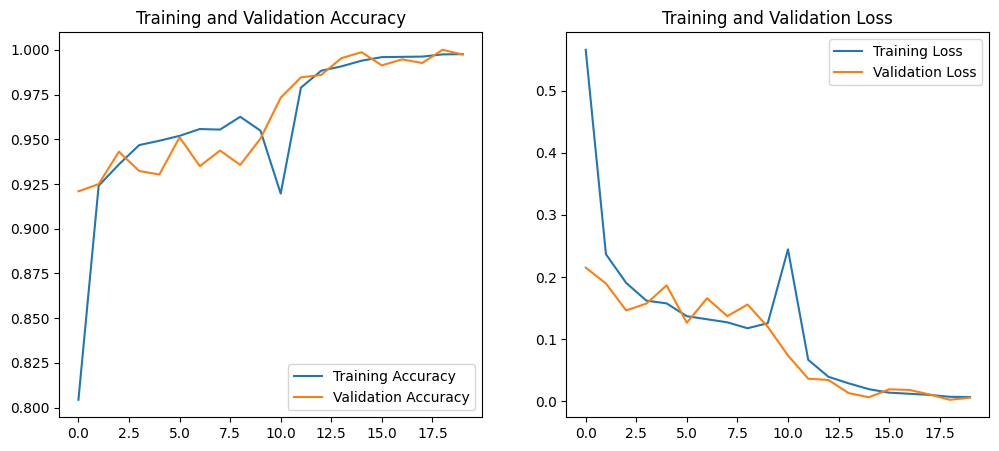

In [40]:
# Plot training accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(total_epochs), acc, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(total_epochs), loss, label='Training Loss')
plt.plot(range(total_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


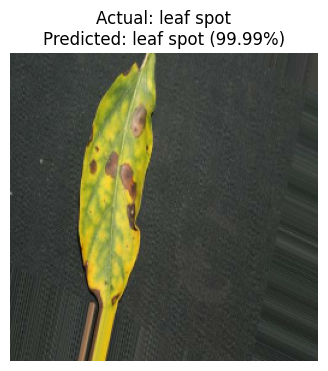

Image 1 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 0.01%
healthy: 0.00%
leaf spot: 99.99%
micronutrient deficiency: 0.00%
up curl: 0.00%




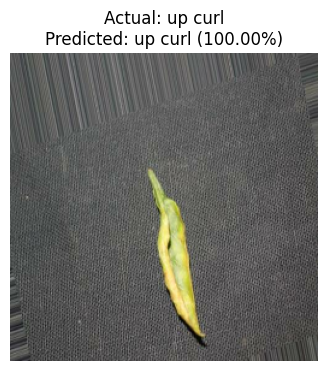

Image 2 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 0.00%
healthy: 0.00%
leaf spot: 0.00%
micronutrient deficiency: 0.00%
up curl: 100.00%




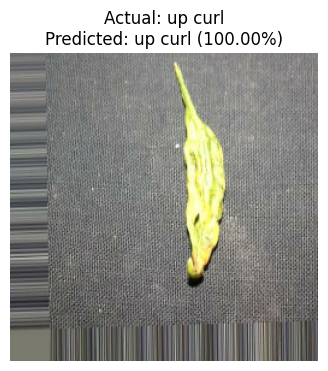

Image 3 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 0.00%
healthy: 0.00%
leaf spot: 0.00%
micronutrient deficiency: 0.00%
up curl: 100.00%




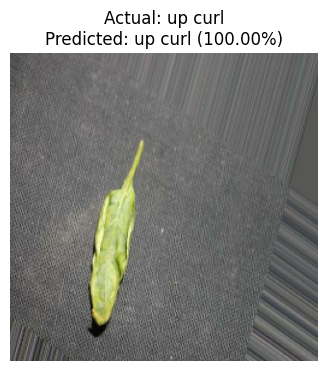

Image 4 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 0.00%
healthy: 0.00%
leaf spot: 0.00%
micronutrient deficiency: 0.00%
up curl: 100.00%




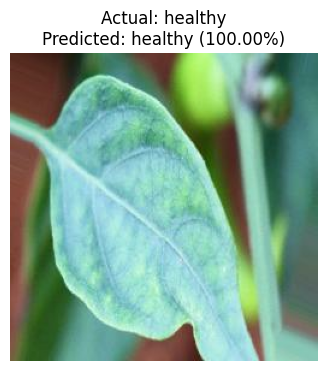

Image 5 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 0.00%
healthy: 100.00%
leaf spot: 0.00%
micronutrient deficiency: 0.00%
up curl: 0.00%




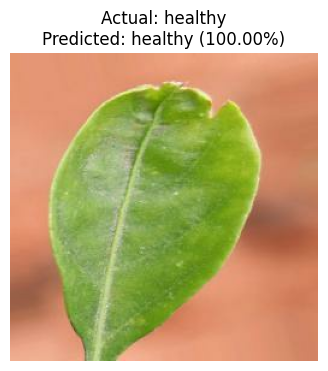

Image 6 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 0.00%
healthy: 100.00%
leaf spot: 0.00%
micronutrient deficiency: 0.00%
up curl: 0.00%




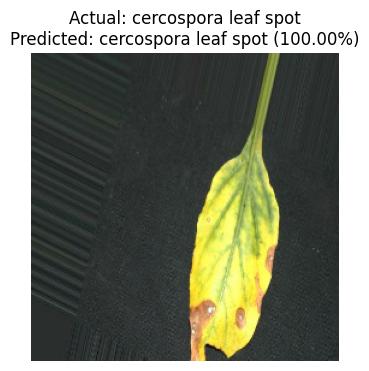

Image 7 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 100.00%
healthy: 0.00%
leaf spot: 0.00%
micronutrient deficiency: 0.00%
up curl: 0.00%




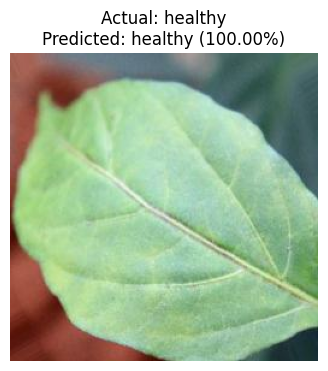

Image 8 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 0.00%
healthy: 100.00%
leaf spot: 0.00%
micronutrient deficiency: 0.00%
up curl: 0.00%




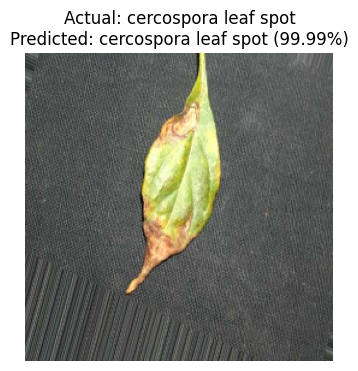

Image 9 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 99.99%
healthy: 0.00%
leaf spot: 0.00%
micronutrient deficiency: 0.00%
up curl: 0.00%




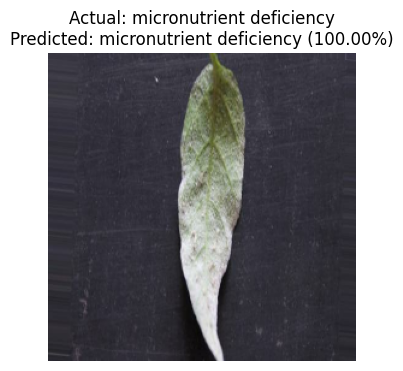

Image 10 Prediction Probabilities:
Bacterial leaf spot: 0.00%
cercospora leaf spot: 0.00%
healthy: 0.00%
leaf spot: 0.00%
micronutrient deficiency: 100.00%
up curl: 0.00%




In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Initialize variables
display_count = 10  # Total number of images to display
selected_images = []  # To store selected images and their details

# Loop through the dataset
for images_batch, labels_batch in test_ds:
    for i in range(len(images_batch)):
        if len(selected_images) >= display_count:
            break

        # Get the current image and label
        current_image = images_batch[i].numpy().astype('uint8')
        current_label = labels_batch[i].numpy()
        actual_class_name = class_names[current_label]

        # Predict the class
        batch_prediction = model.predict(images_batch)
        predicted_class_idx = np.argmax(batch_prediction[i])
        predicted_class_name = class_names[predicted_class_idx]
        confidence = batch_prediction[i][predicted_class_idx]

        # Store the image and prediction details
        selected_images.append({
            "image": current_image,
            "actual": actual_class_name,
            "predicted": predicted_class_name,
            "confidence": confidence,
            "probabilities": batch_prediction[i]
        })

    if len(selected_images) >= display_count:
        break

# Randomly sample from selected images (to ensure randomness if the dataset has bias)
random.shuffle(selected_images)

# Display the selected images
for idx, img_info in enumerate(selected_images[:display_count]):
    plt.figure(figsize=(4, 4))
    plt.imshow(img_info["image"])
    plt.title(f"Actual: {img_info['actual']}\n"
              f"Predicted: {img_info['predicted']} ({img_info['confidence'] * 100:.2f}%)")
    plt.axis('off')
    plt.show()

    # Print probabilities for all classes
    print(f"Image {idx + 1} Prediction Probabilities:")
    for j, prob in enumerate(img_info["probabilities"]):
        print(f"{class_names[j]}: {prob * 100:.2f}%")
    print("\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

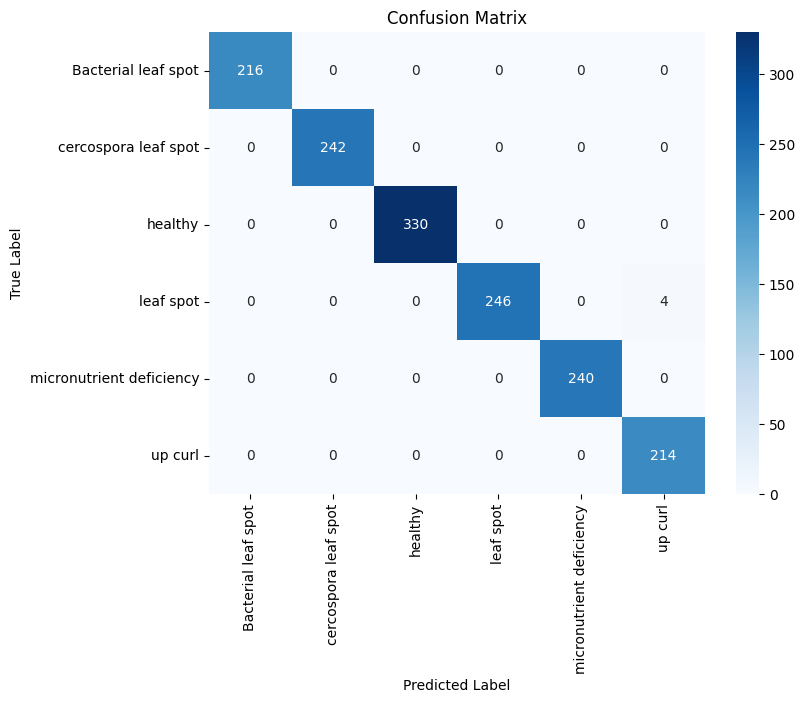

In [42]:
# Confusion matrix and classification report
y_true = []
y_pred = []
for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=-1))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [43]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


                          precision    recall  f1-score   support

     Bacterial leaf spot       1.00      1.00      1.00       216
    cercospora leaf spot       1.00      1.00      1.00       242
                 healthy       1.00      1.00      1.00       330
               leaf spot       1.00      0.98      0.99       250
micronutrient deficiency       1.00      1.00      1.00       240
                 up curl       0.98      1.00      0.99       214

                accuracy                           1.00      1492
               macro avg       1.00      1.00      1.00      1492
            weighted avg       1.00      1.00      1.00      1492



In [44]:
# Save the model in .keras format
model.save('chilli_resnet50.keras')
